Goal - look at correlations between Belle Isle transport and shelf transports

In [1]:
import glob
import os

from geopy.distance import distance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import transport

import scipy.stats

In [2]:
lon_min=-70
lat_min=40
lon_max=-40
lat_max=70

In [3]:
data_dir='/ocean/handres/glorys12/'
mask = xr.open_dataset(os.path.join(data_dir,'statics_subset_mask_bathy.nc'))
mask = mask.sel(latitude=slice(lat_min, lat_max),
                longitude=slice(lon_min, lon_max))
coords = xr.open_dataset(os.path.join(data_dir,'statics_subset_coordinates.nc'))
coords = coords.sel(latitude=slice(lat_min, lat_max),
                    longitude=slice(lon_min, lon_max),
                   )

In [4]:
transects = pd.read_csv('NL-transects.csv')
                       #names=['Shortname', 'Longname', 'lon1', 'lat1', 'lon2', 'lat2', 'Dir-E', 'Dir-N'],
                       #header=0)

In [5]:
data_dir='/home/soontiensn/data/cmems2020-oceanstatereport/data/netcdf/GLORYSv12/monthly-means/'
f = glob.glob(os.path.join(data_dir,'*_JJA.nc'))
d = xr.open_mfdataset(f)
dsel = d.sel(
             latitude=slice(lat_min, lat_max),
             longitude=slice(lon_min, lon_max))

# Functions for cummulative transport

In [6]:
def cummulative_transport(across, transect, mask, e3t):
    lons = across.longitude.values
    lats = across.latitude.values
    dir_east_perp = transect['Dir-E'].values[0]
    dir_north_perp = transect['Dir-N'].values[0]
    transect_vector = transport.vectorize_transect(lons, lats,
                                             dir_east_perp,
                                             dir_north_perp)
    mask_transect = transport.interpolate_transect(mask, lons, lats, method='nearest')
    e3t_transect = transport.interpolate_transect(e3t, lons, lats, method='nearest')
    H = (mask_transect*e3t_transect).sum(dim='depth', skipna=True)
    H = H.where(H!=0)
    across_depth_int = transport.depth_integrate(across, mask_transect, e3t_transect)
    cumm_transport =  (across_depth_int[:,:-1]*np.abs(transect_vector)).cumsum(dim='transect')
    distance = np.abs(transect_vector).cumsum()/1e3
    return cumm_transport, distance, H

In [7]:
def plot_cumm_transport(cumm_transort, distance, H,  name):

    fig,axs = plt.subplots(2,1, figsize=(10,10))
    ax=axs[0]
    for i in range(cumm_transport.shape[0]):
        ax.plot(distance, cumm_transport.isel(time=i)/1e6)
    ax.set_ylabel('Cummulative transport [Sv]')
    ax.set_title(name)
    ax2=axs[1]
    ax2.plot(distance, H[:-1], 'k')
    ax2.set_ylim([3000,0])
    ax2.set_ylabel('depth [m]')
    ax2.grid()

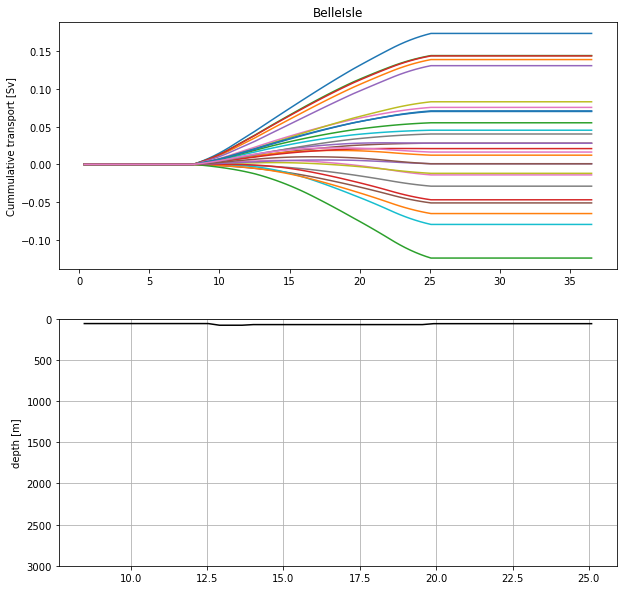

In [8]:
name = 'BelleIsle'
transect=transects[transects['Longname']==name]
tfull, along, across = transport.get_transect_transport(
    dsel.uo, dsel.vo, 
    mask.mask, coords.e3t, transect, barotropic=False)
cumm_transport, distance, H = cummulative_transport(across, transect, mask.mask, coords.e3t)
    
plot_cumm_transport(cumm_transport, distance, H, name)
belle = cumm_transport.dropna(dim='transect').isel(transect=-1)

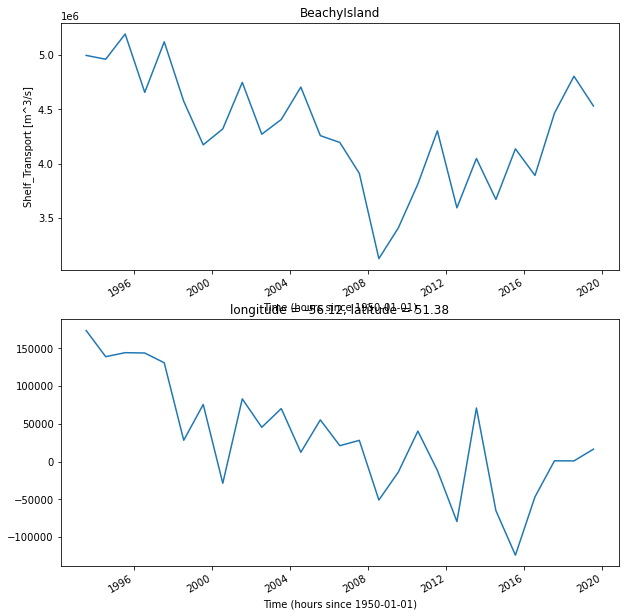

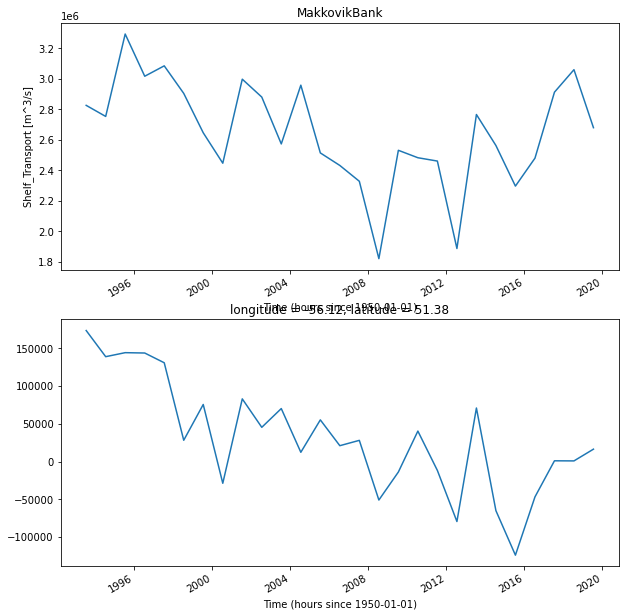

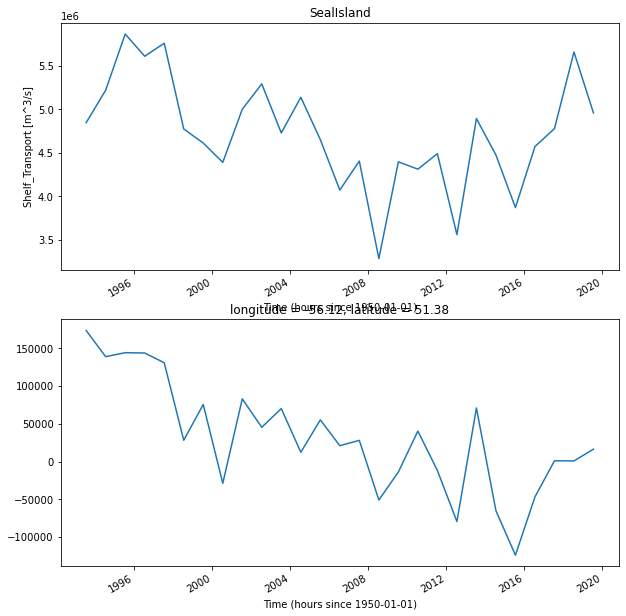

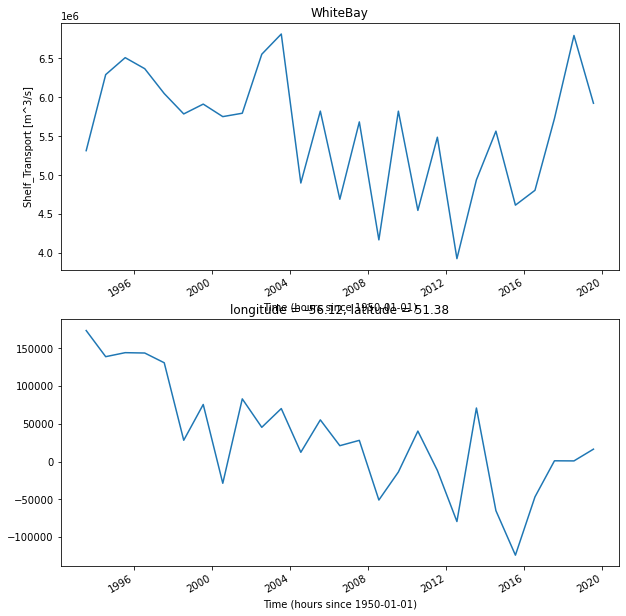

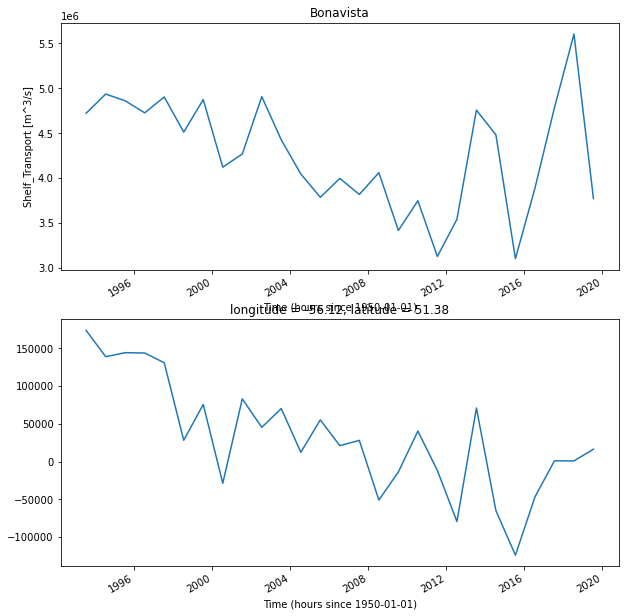

In [9]:
for name in ['BeachyIsland', 'MakkovikBank', 'SealIsland', 'WhiteBay', 'Bonavista']:
    d = xr.open_dataset(f'{name}.nc')
    fig, axs = plt.subplots(2,1,figsize=(10,10))
    ax=axs[0]
    d.Shelf_Transport.plot(ax=ax)
    ax.set_title(name)
    ax=axs[1]
    belle.plot(ax=ax)
    

In [18]:
def correlation_lagged( belle, other, lag_year,ax):
    if lag_year >0:
        x = belle[0:-lag_year]
        y = other[lag_year:]
    elif lag_year ==0:
        x = belle
        y = other
    else:
        x = belle[-lag_year:]
        y = other[:lag_year]
    r, p = scipy.stats.pearsonr(x,y )
    ax.scatter(x,y)
    ax.set_ylabel('Belle transport [m^3/s]')
    ax.set_title(f'Lag year {lag_year} and r= {r:0.3f}')
    return r

In [14]:
lag_years = [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1, 0,1,2,3,4,5,6,7,8,9,10]

Text(0.5, 1.0, 'BeachyIsland')

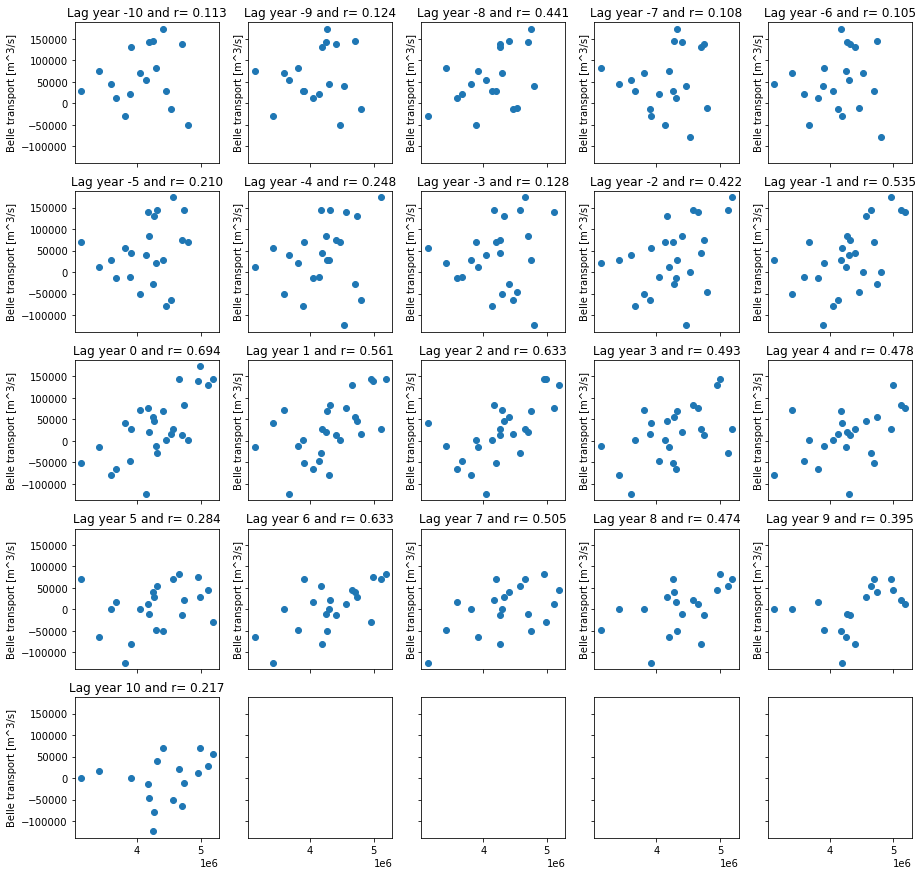

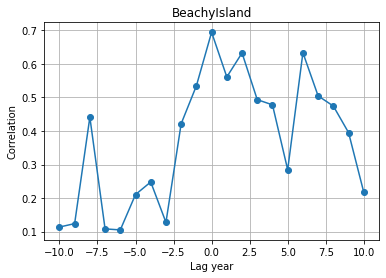

In [19]:
name='BeachyIsland'

fig,axs = plt.subplots(5,5,figsize=(15,15),sharex=True,sharey=True)
d = xr.open_dataset(f'{name}.nc')
rs = []
for lag_year, ax in zip(lag_years, axs.flatten()):
    r = correlation_lagged(d.Shelf_Transport.values, belle.values,lag_year, ax)
    rs.append(r)
    
fig, ax = plt.subplots(1,1)
ax.plot(lag_years, rs, 'o-')
ax.set_xlabel('Lag year')
ax.set_ylabel('Correlation')
ax.grid()
ax.set_title(name)

Text(0.5, 1.0, 'MakkovikBank')

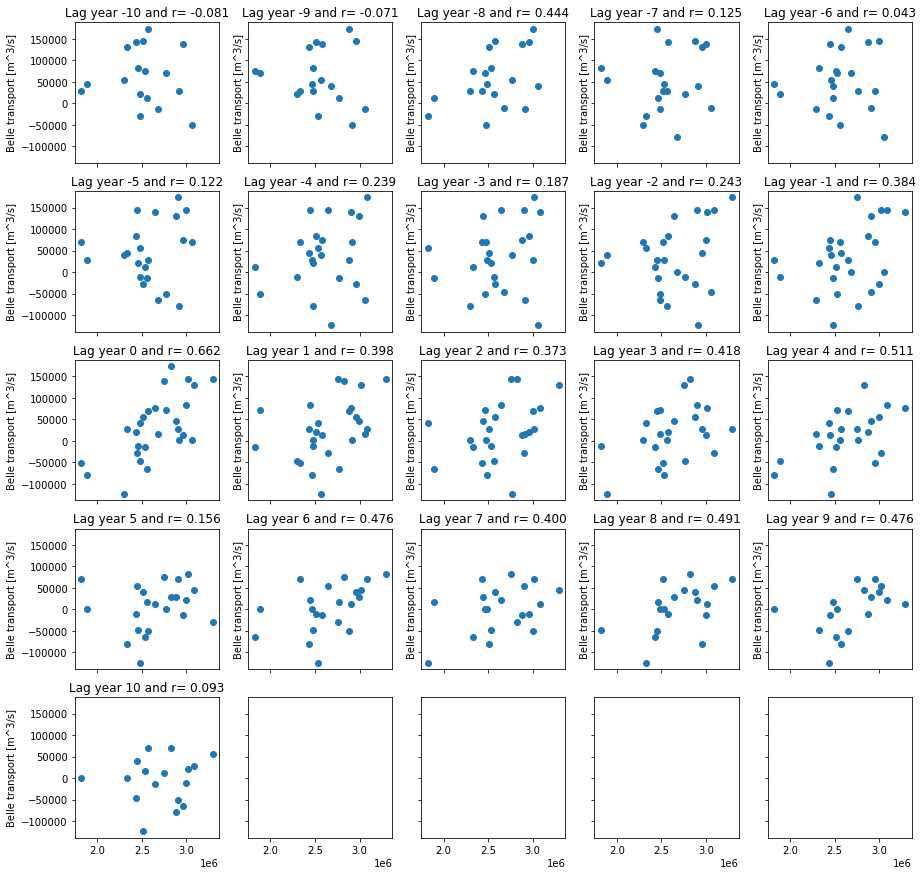

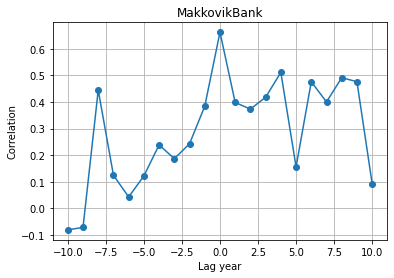

In [21]:
name='MakkovikBank'

fig,axs = plt.subplots(5,5,figsize=(15,15),sharex=True,sharey=True)
d = xr.open_dataset(f'{name}.nc')
rs = []
for lag_year, ax in zip(lag_years, axs.flatten()):
    r = correlation_lagged(d.Shelf_Transport.values, belle.values,lag_year, ax)
    rs.append(r)
    
fig, ax = plt.subplots(1,1)
ax.plot(lag_years, rs, 'o-')
ax.set_xlabel('Lag year')
ax.set_ylabel('Correlation')
ax.grid()
ax.set_title(name)

Text(0.5, 1.0, 'SealIsland')

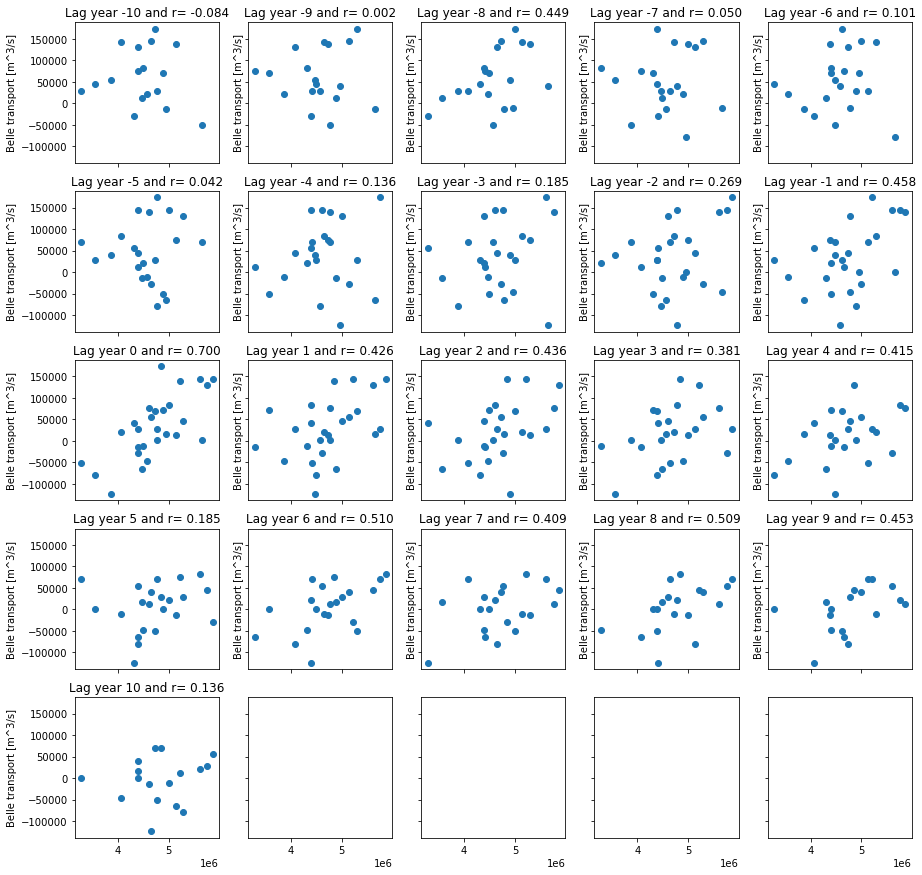

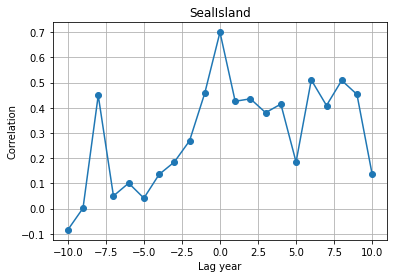

In [22]:
name='SealIsland'

fig,axs = plt.subplots(5,5,figsize=(15,15),sharex=True,sharey=True)
d = xr.open_dataset(f'{name}.nc')
rs = []
for lag_year, ax in zip(lag_years, axs.flatten()):
    r = correlation_lagged(d.Shelf_Transport.values, belle.values,lag_year, ax)
    rs.append(r)
    
fig, ax = plt.subplots(1,1)
ax.plot(lag_years, rs, 'o-')
ax.set_xlabel('Lag year')
ax.set_ylabel('Correlation')
ax.grid()
ax.set_title(name)

Text(0.5, 1.0, 'WhiteBay')

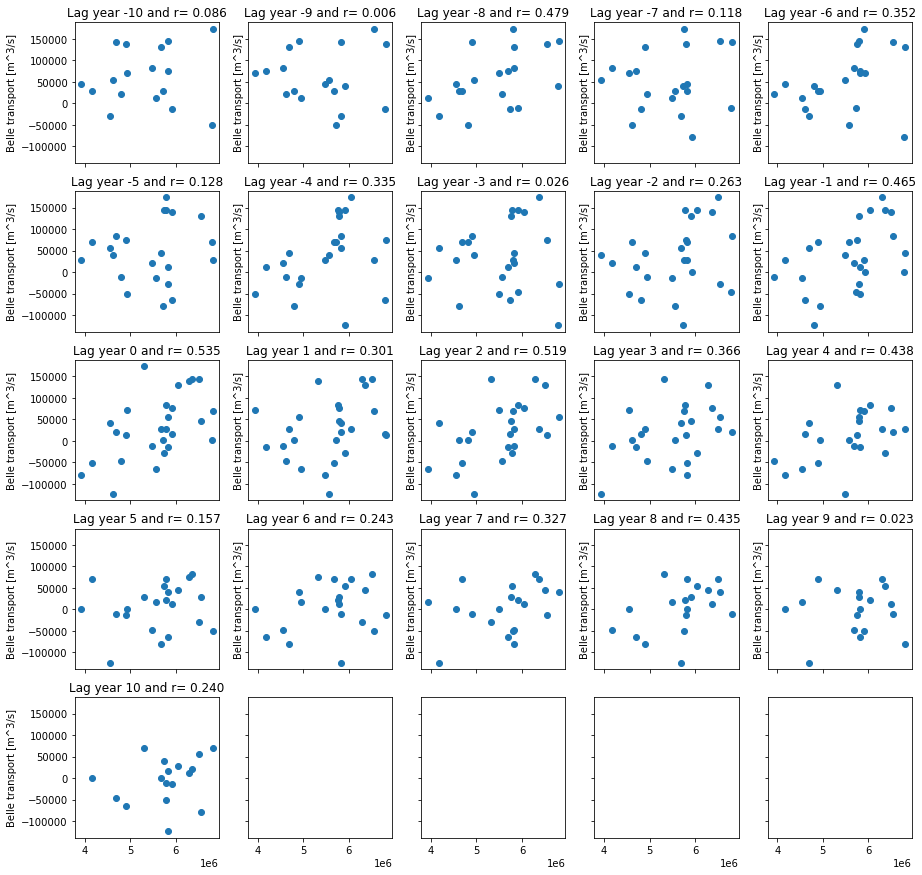

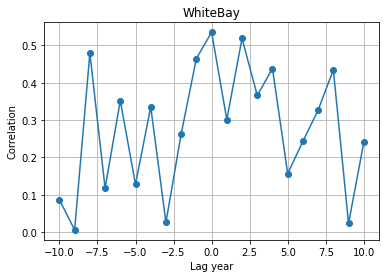

In [23]:
name='WhiteBay'

fig,axs = plt.subplots(5,5,figsize=(15,15),sharex=True,sharey=True)
d = xr.open_dataset(f'{name}.nc')
rs = []
for lag_year, ax in zip(lag_years, axs.flatten()):
    r = correlation_lagged(d.Shelf_Transport.values, belle.values,lag_year, ax)
    rs.append(r)
    
fig, ax = plt.subplots(1,1)
ax.plot(lag_years, rs, 'o-')
ax.set_xlabel('Lag year')
ax.set_ylabel('Correlation')
ax.grid()
ax.set_title(name)

Text(0.5, 1.0, 'Bonavista')

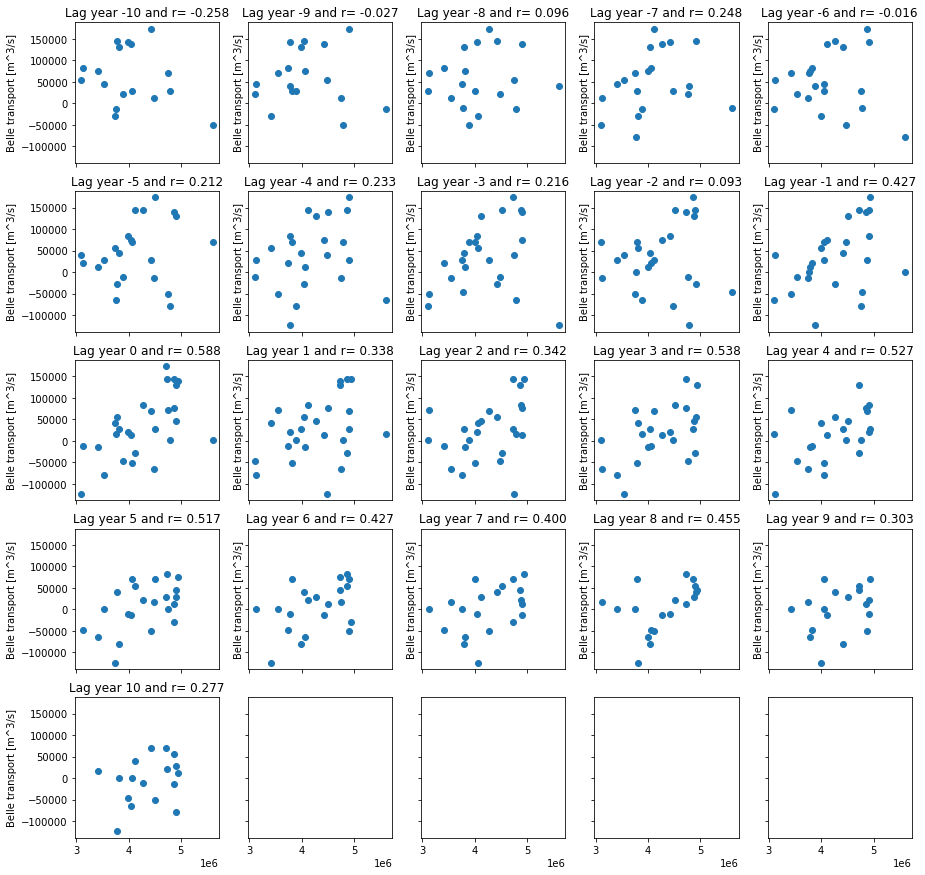

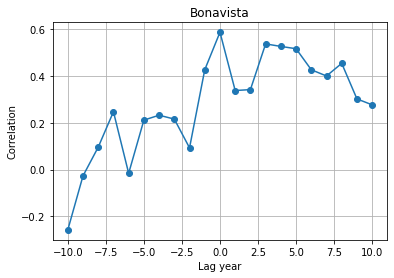

In [24]:
name='Bonavista'

fig,axs = plt.subplots(5,5,figsize=(15,15),sharex=True,sharey=True)
d = xr.open_dataset(f'{name}.nc')
rs = []
for lag_year, ax in zip(lag_years, axs.flatten()):
    r = correlation_lagged(d.Shelf_Transport.values, belle.values,lag_year, ax)
    rs.append(r)
    
fig, ax = plt.subplots(1,1)
ax.plot(lag_years, rs, 'o-')
ax.set_xlabel('Lag year')
ax.set_ylabel('Correlation')
ax.grid()
ax.set_title(name)